---
# URL Reputation
### Adrien Manciet - Thibault Sourdeval
---

### Introduction

Ce dataset est un ensemble d'url qui sont labellisés. Si le label vaut 1, l'url est malsain, si il vaut -1, il ne l'est pas. L'objectif sera de faire un algorithme de classification des urls en apprenant sur le dataset disponible. 

---
# Partie 1 - Phase d'exploration
---

Nous notons que les fichiers de données sont sous la forme de matrices sparse. Cela signifie que seules les valeurs non nulles sont gardées en mémoire. 
Cela permet d'épargner des erreurs de mémoire. 

Le fichier features contient des numéros qui semblent correspondre à des subdivisions de l'url contenant en blocs. Exemple : la première ligne du fichier features affiche 4, ce qui pourrait correspondre aux quatres premiers caractères de l'url 'http'. 

Nous codons une fonction de prévisualisation pour mieux comprendre la structure des données en les transformant en un dataframe. Pour la suite, 
nous resterons dans le format de données initial.

**Chargement des modules**

In [1]:
from sklearn.datasets import load_svmlight_file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time


**Fonction de prévisualisation** 

In [2]:
def preview_data(day, nb_lines, nb_cols, random = True):
    # Si random est laissé tel quel, une valeur au hasard 
    # est prise pour la première ligne et la première colonne à afficher

    path =f"url_svmlight/url_svmlight/Day{day}.svm"
    X, y = load_svmlight_file(path)
    print("Les données sont de taille : ", X.shape)

    if random == True:
        start_line = np.random.randint(0, len(y)-nb_lines)
        start_col = np.random.randint(0,X.shape[1])
    else : 
        start_line = int(input("Première ligne à afficher : "))
        start_col = int(input("Première colonne à afficher : "))
    
    label_list = []
    for i in range(start_col, start_col+nb_cols):
        label_list.append(i)

    X_df = pd.DataFrame(X[start_line: start_line+nb_lines, start_col: start_col+nb_cols].toarray(), columns=label_list)
    y_df = pd.DataFrame(y[start_line: start_line+nb_lines], columns=['label'])

    data = pd.concat([X_df, y_df], axis=1)
    return data

preview_data(17, 10, 10, random=False)


Les données sont de taille :  (20000, 3231939)


,17,18,19,20,21,22,23,24,25,26,label
0,0.822980,0.854082,0.0,0.023808,0.023810,0.023810,1.0,0.0,0.0,0.0,-1.0
1,0.816571,0.146394,1.0,0.285711,0.005952,0.000000,0.0,0.0,0.0,0.0,-1.0
2,0.737675,0.583909,0.0,0.285713,0.011905,0.000000,1.0,1.0,0.0,0.0,-1.0
3,0.752946,0.497025,0.0,0.035713,0.035714,0.035714,1.0,1.0,0.0,0.0,-1.0
4,0.749562,0.389203,0.0,0.142856,0.002976,0.002976,1.0,1.0,0.0,0.0,-1.0
5,0.000000,0.000000,0.0,0.142856,0.000124,0.002976,1.0,1.0,0.0,0.0,-1.0
6,0.829972,0.176387,1.0,0.142856,0.023810,0.023810,0.0,0.0,0.0,0.0,-1.0
7,0.000000,0.000000,0.0,0.000494,0.000496,0.000000,1.0,1.0,0.0,1.0,-1.0
8,0.752830,0.184004,0.0,0.142856,0.142857,0.142857,1.0,1.0,0.0,0.0,-1.0
9,0.840932,0.196630,0.0,0.005951,0.005952,0.000000,1.0,1.0,0.0,0.0,-1.0


**Visualisations grahiques** 

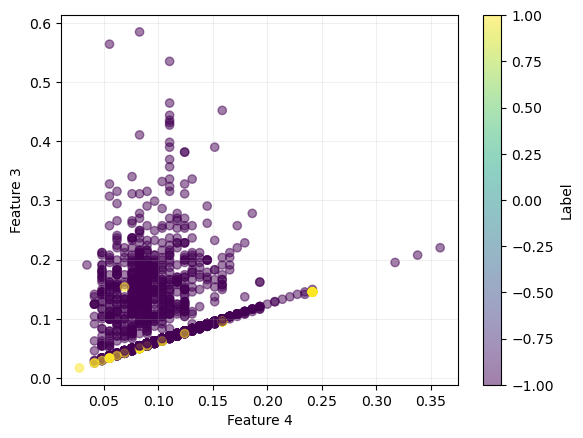

In [3]:
def scatter_plot(day, feature_x, feature_y): 
    path =f"url_svmlight/url_svmlight/Day{day}.svm"
    X, y = load_svmlight_file(path)

    X = X[0:2000,:2000].toarray()
    plt.figure()
    plt.grid(alpha=0.2)
    sc = plt.scatter(X[:,feature_x], X[:,feature_y], c=y[0:2000], cmap="viridis",alpha=0.5)
    plt.xlabel(f'Feature {feature_x}')
    plt.ylabel(f'Feature {feature_y}')
    

    cbar = plt.colorbar(sc)
    cbar.set_label("Label")
    plt.show()

scatter_plot(11,4,3)

**Commentaires sur les features**

Elles ne correspondent pas à des critères interprétables par l'humain. Probablement, ce sont des indicateurs de présence de certains mots, ou certains caractères dans un découpage de l'url qui est défini dans le fichier `features_types`.

**PCA**

Voyons ce qu'une PCA sur un fichier de notre jeu de données peut donner, si cela peut nous aider à identifier des combinaisons linéaires de features qui capturent la variance de notre jeu de données. 

In [6]:
from sklearn.decomposition import TruncatedSVD

X, y = load_svmlight_file('url_svmlight/url_svmlight/Day17.svm')

svd = TruncatedSVD(n_components=10)
X_svd = svd.fit_transform(X)
# print(X_svd.shape)


[0.01643785 0.10954859 0.07216986 0.04052315 0.03569221 0.02662799
 0.01977647 0.01634824 0.01523854 0.01344933]


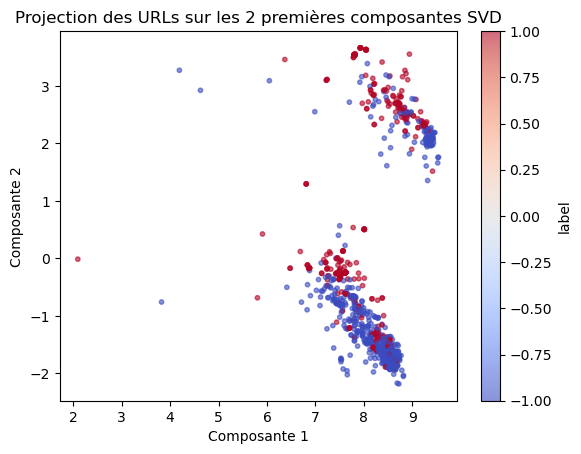

In [7]:
print(svd.explained_variance_ratio_)
plt.scatter(X_svd[:1000,0], X_svd[:1000,1], c=y[:1000], cmap='coolwarm', s=10, alpha=0.6)
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.title('Projection des URLs sur les 2 premières composantes SVD')
plt.colorbar(label='label')
plt.show()

 
Nous constatons qu'il est difficile de capturer la variance de notre jeu de données sur quelques composantes seulement. Cela confirme ce que nous avons constaté en affichant quelques colonnes du jeu de données dans les lignes précédentes. 

Vu le faible niveau de variance expliquée par cette PCA, nous avons décidé de ne pas y recourir pour réduire les dimensions de notre jeu de données dans la partie feature engineering, et de plutôt appliquer un critère de variance minimale.



---
# Partie 2 - Feature Engineering
---

Comme beaucoup de nos colonnes de features ne contiennent que des 0 ou des 1, et que cela ne permettra pas la classification, nous décidons d'enlever ces colonnes dans les données qui serviront à l'apprentissage. 

Pour ce faire, nous utilisons un critère sur la variance minimale d'une colonne dans chaque fichier. Puis, nous regardons le nombre de fichier pour lesquel une colonne a été gardée. Nous mesurons cela en pourcentage. 
>Exemple : la colonne 1 a une variance supérieure au critère minimal dans les fichiers 1 à 10, mais pas dans les fichiers 11 à 20. Ainsi, l'algorithme a gardé la colonne un pour les fichiers 1 à 10 et l'a enlevée dans les autres. Au total, la colonne 1 a été gardée dans 50% des cas.

Nous gardons les colonnes dès lors qu'elles sont gardées au moins une fois, soit que leur pourcentage d'apparition est strictement positif. 

### Sélection des features 

**Trouver les features à garder**

In [2]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import load_svmlight_file
import os

data_dir = "url_svmlight/url_svmlight"
max_features = 3300000  # à adapter à ton dataset

selector = VarianceThreshold(threshold=0.01)

# Préparer la liste des fichiers à traiter
files_to_process = sorted(os.listdir(data_dir))[:10]  # exemple sur 10 jours
num_files = len(files_to_process)

# Initialiser UN SEUL tableau pour compter les sélections
# C'est beaucoup plus efficace en mémoire
column_keep_counts = np.zeros(max_features, dtype=int)

print(f"Traitement de {num_files} fichiers...")

# Boucle sur les fichiers
for file in files_to_process:
    X, y = load_svmlight_file(os.path.join(data_dir, file), n_features=max_features)
    
    # On a seulement besoin de "fit", pas de "fit_transform" si on n'utilise pas X_reduced
    selector.fit(X) 
    
    keep_mask = selector.get_support()  # booléen : True si la colonne est gardée
    
    # --- La voici, l'optimisation ---
    # On ajoute le masque (True=1, False=0) à notre compteur total
    column_keep_counts += keep_mask
    # ---------------------------------
    print(f"Traitement {file} terminé.")

print("Traitement terminé.")

# Calculer le pourcentage (exactement comme avant, mais sans la grosse matrice)
column_keep_percentage = (column_keep_counts / num_files) * 100

# Créer DataFrame en ne gardant que les colonnes qui ont été sélectionnées au moins une fois
df_keep = pd.DataFrame({
    'column_index': np.arange(len(column_keep_percentage)),
    'percent_kept': column_keep_percentage
})

# Filtrer les colonnes jamais gardées
df_keep = df_keep[df_keep['percent_kept'] > 0]	

Traitement de 10 fichiers...
Traitement Day0.svm terminé.
Traitement Day1.svm terminé.
Traitement Day10.svm terminé.
Traitement Day100.svm terminé.
Traitement Day101.svm terminé.
Traitement Day102.svm terminé.
Traitement Day103.svm terminé.
Traitement Day104.svm terminé.
Traitement Day105.svm terminé.
Traitement Day106.svm terminé.
Traitement terminé.


**Filtrer et concaténer toutes les données chargées en ne conservant que les features sélectionnées précédemment**

In [3]:
from scipy.sparse import vstack, csr_matrix
from sklearn.datasets import load_svmlight_file

data_dir = "url_svmlight/url_svmlight"

X_filtered_all = None
y_all = []

# -------------------------------
# Boucle sur les fichiers
# -------------------------------
for file in sorted(os.listdir(data_dir))[:10]:
    print(f"Traitement de {file}...")
    X, y = load_svmlight_file(os.path.join(data_dir, file), n_features=max_features)
    
    # Filtrage sur les mêmes colonnes
    X_filtered = X[:, df_keep['column_index']]
    
    # Concaténation verticale
    if X_filtered_all is None:
        X_filtered_all = X_filtered
    else:
        X_filtered_all = vstack([X_filtered_all, X_filtered])
    
    y_all.append(y)

# -------------------------------
# Concaténer les labels
# -------------------------------
y_all = np.concatenate(y_all)

# -------------------------------
# Vérification finale
# -------------------------------
print("Shape finale :", X_filtered_all.shape)
print("Nombre total d'échantillons :", X_filtered_all.shape[0])
print("Nombre de colonnes (features) :", X_filtered_all.shape[1])


Traitement de Day0.svm...
Traitement de Day1.svm...
Traitement de Day10.svm...
Traitement de Day100.svm...
Traitement de Day101.svm...
Traitement de Day102.svm...
Traitement de Day103.svm...
Traitement de Day104.svm...
Traitement de Day105.svm...
Traitement de Day106.svm...
Shape finale : (196000, 848)
Nombre total d'échantillons : 196000
Nombre de colonnes (features) : 848


**Séparation du jeu de données en train et test**

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler

# Définir la taille du jeu de test (ex: 20%)
TAILLE_TEST = 0.2

# 1. Créer le split principal (Train / Test)
# Le jeu de test (X_test, y_test) ne sera plus touché avant l'évaluation finale.
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_filtered_all, 
    y_all, 
    test_size=TAILLE_TEST, 
    stratify=y_all,  # Garde les proportions de classes
    random_state=42 # Pour la reproductibilité
)


Nous appliquons un scaler, le `MaxAbsScaler` est plus adapté que le `StandardScaler` pour des données clairsemées (sparse), c'est-à-dire contenant beaucoup de zéros. Ceci est bien le cas de notre jeu de données, d'où l'utilisation de cette méthode de pré-traitement des données.

In [5]:

scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

print(f"Taille dataset complet : {X_filtered_all.shape[0]} échantillons")
print(f"Taille jeu d'entraînement complet : {X_train_full.shape[0]} échantillons")
print(f"Taille jeu de test : {X_test.shape[0]} échantillons")

Taille dataset complet : 196000 échantillons
Taille jeu d'entraînement complet : 156800 échantillons
Taille jeu de test : 39200 échantillons


**Option : réduction de la taille des jeux de données précédents pour entraîner des modèles de manière exploratoire**

In [6]:
# Définir la fraction du jeu d'entraînement que vous voulez garder
# Ex: 0.1 (soit 10% du X_train_full, ou 8% du dataset total)
TAILLE_TRAIN_REDUIT = 0.1 

# 2. Créer l'échantillon réduit à partir du jeu d'entraînement
# On utilise train_size cette fois-ci.
# Les '_' sont pour les variables que nous n'utiliserons pas (le reste des données)
X_train_reduced, _, y_train_reduced, _ = train_test_split(
    X_train_full, 
    y_train_full, 
    train_size=TAILLE_TRAIN_REDUIT, 
    stratify=y_train_full, # Garde les proportions de classes
    random_state=42
)

print(f"\nTaille jeu d'entraînement réduit : {X_train_reduced.shape[0]} échantillons")


Taille jeu d'entraînement réduit : 15680 échantillons


---
# Partie 3 - Phase d'apprentissage
---

## Passage en revue des méthodes d'apprentissage 

Nous commençons par faire un passage en revue des différentes méthodes sur notre jeu de données. Une de nos contraintes principales concerne la taille du jeu de données. Ainsi, nous commençons par évaluer le temps d'execution ainsi que les performances (précisions, variances) des différentes méthodes sur un jeu de données réduit. Nous appliquons ensuite la meilleure méthode au jeu de données entier.

### SVM

**SVM Linéaire**

In [8]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

start = time.time()

svm = LinearSVC(random_state=42)
svm.fit(X_train_reduced, y_train_reduced)
y_pred = svm.predict(X_test)

end = time.time()

print("\n--- Évaluation du modèle ---")
print(f"Temps d'exécution :{end - start:.2f} s")
print('Précision de : ', accuracy_score(y_test, y_pred))
print("\nRésumé de classification:\n", classification_report(y_test, y_pred))
print("\nMatrice de confusion:\n", confusion_matrix(y_test,y_pred))


--- Évaluation du modèle ---
Temps d'exécution :0.35 s
Précision de :  0.9723469387755102

Résumé de classification:
               precision    recall  f1-score   support

        -1.0       0.98      0.98      0.98     25216
         1.0       0.96      0.96      0.96     13984

    accuracy                           0.97     39200
   macro avg       0.97      0.97      0.97     39200
weighted avg       0.97      0.97      0.97     39200


Matrice de confusion:
 [[24704   512]
 [  572 13412]]


Le résultat est déjà satisfaisant, ce qui peut laisser présupposer d'une structure multi-linéaire de notre jeu de données.

In [ ]:
from sklearn.svm import SVC

start = time.time()

svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_reduced, y_train_reduced)
y_pred = svm.predict(X_test)

end = time.time()

print("\n--- Évaluation du modèle ---")
print(f"Temps d'exécution : {end - start:.2f} s")
print('Précision de : ', accuracy_score(y_test, y_pred))
print("\nRésumé de classification:\n", classification_report(y_test, y_pred))
print("\nMatrice de confusion:\n", confusion_matrix(y_test,y_pred))

Ici, le temps d'execution est plus long, sans d'amélioration significative de la précision et de la variance. C'est un résultat auquel on pouvait s'attendre puisque svm linéaire donnait de bons résultats, indiquant que notre jeu de données pouvait être séparé linéairement.

### Naive Bayes

**Avec une distribution de probabilité de Bernoulli**

Nos données contiennent beaucoup de 0 et de 1, ce qui se prête bien à une modélisation par une loi de Bernoulli (pile ou face avec une certaine probabilité).

In [30]:
from sklearn.naive_bayes import BernoulliNB

start = time.time()

model = BernoulliNB(alpha=0.1, binarize=None)  # binarize=None car tes features sont déjà binaires
model.fit(X_train_reduced, y_train_reduced)

y_pred = model.predict(X_test)

end = time.time()

print("\n--- Évaluation du modèle ---")
print(f"Temps d'exécution : {end - start:.2f} s")
print('Précision de : ', accuracy_score(y_test, y_pred))
print("\nRésumé de classification:\n", classification_report(y_test, y_pred))
print("\nMatrice de confusion:\n", confusion_matrix(y_test,y_pred))


--- Évaluation du modèle ---
Temps d'exécution : 0.03 s
Précision de :  0.903545918367347

Résumé de classification:
               precision    recall  f1-score   support

        -1.0       0.90      0.95      0.93     25216
         1.0       0.91      0.81      0.86     13984

    accuracy                           0.90     39200
   macro avg       0.90      0.88      0.89     39200
weighted avg       0.90      0.90      0.90     39200


Matrice de confusion:
 [[24037  1179]
 [ 2602 11382]]


**Processus Gaussiens**

Testé mais trop long.

### Algorithmes basés sur les arbres de décisions

**Arbre de décision simple**

In [31]:
from sklearn import tree

start = time.time()

model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
model.fit(X_train_reduced, y_train_reduced)
y_pred = model.predict(X_test)

end = time.time()

print("\n--- Évaluation du modèle ---")
print(f"Temps d'exécution : {end - start:.2f} s")
print('Précision de : ', accuracy_score(y_test, y_pred))
print("\nRésumé de classification:\n", classification_report(y_test, y_pred))
print("\nMatrice de confusion:\n", confusion_matrix(y_test,y_pred))


--- Évaluation du modèle ---
Temps d'exécution : 0.08 s
Précision de :  0.9563775510204081

Résumé de classification:
               precision    recall  f1-score   support

        -1.0       0.98      0.95      0.97     25216
         1.0       0.91      0.97      0.94     13984

    accuracy                           0.96     39200
   macro avg       0.95      0.96      0.95     39200
weighted avg       0.96      0.96      0.96     39200


Matrice de confusion:
 [[23899  1317]
 [  393 13591]]


L'arbre de décision est rapide et précis, cependant, nous avons vu que utilisé seul, ses capacités de généralisation sont limitées. 

**AdaBoost**

In [34]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree

start = time.time()

model = AdaBoostClassifier(tree.DecisionTreeClassifier(criterion='entropy', max_depth=3), n_estimators=100)
model.fit(X_train_reduced, y_train_reduced)
y_pred = model.predict(X_test)

end = time.time()

print("\n--- Évaluation du modèle ---")
print(f"Temps d'exécution : {end - start:.2f} s")
print('Précision de : ', accuracy_score(y_test, y_pred))
print("\nRésumé de classification:\n", classification_report(y_test, y_pred))
print("\nMatrice de confusion:\n", confusion_matrix(y_test,y_pred))


--- Évaluation du modèle ---
Temps d'exécution : 6.50 s
Précision de :  0.9747959183673469

Résumé de classification:
               precision    recall  f1-score   support

        -1.0       0.98      0.98      0.98     25216
         1.0       0.97      0.96      0.96     13984

    accuracy                           0.97     39200
   macro avg       0.97      0.97      0.97     39200
weighted avg       0.97      0.97      0.97     39200


Matrice de confusion:
 [[24751   465]
 [  523 13461]]


**XGBoost**

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree

start = time.time()

model = GradientBoostingClassifier(n_estimators=100)
model.fit(X_train_reduced, y_train_reduced)
y_pred = model.predict(X_test)

end = time.time()

print("\n--- Évaluation du modèle ---")
print(f"Temps d'exécution : {end - start:.2f} s")
print('Précision de : ', accuracy_score(y_test, y_pred))
print("\nRésumé de classification:\n", classification_report(y_test, y_pred))
print("\nMatrice de confusion:\n", confusion_matrix(y_test,y_pred))


--- Évaluation du modèle ---
Temps d'exécution : 4.80 s
Précision de :  0.9741581632653061

Résumé de classification:
               precision    recall  f1-score   support

        -1.0       0.98      0.98      0.98     25216
         1.0       0.96      0.97      0.96     13984

    accuracy                           0.97     39200
   macro avg       0.97      0.97      0.97     39200
weighted avg       0.97      0.97      0.97     39200


Matrice de confusion:
 [[24671   545]
 [  468 13516]]


**RandomForest**

In [35]:
from sklearn.ensemble import RandomForestClassifier


start = time.time()

model = RandomForestClassifier(n_estimators=100, criterion='entropy')
model.fit(X_train_reduced, y_train_reduced)
y_pred = model.predict(X_test)

end = time.time()

print("\n--- Évaluation du modèle ---")
print(f"Temps d'exécution : {end - start:.2f} s")
print('Précision de : ', accuracy_score(y_test, y_pred))
print("\nRésumé de classification:\n", classification_report(y_test, y_pred))
print("\nMatrice de confusion:\n", confusion_matrix(y_test,y_pred))


--- Évaluation du modèle ---
Temps d'exécution : 7.02 s
Précision de :  0.9757908163265306

Résumé de classification:
               precision    recall  f1-score   support

        -1.0       0.98      0.98      0.98     25216
         1.0       0.97      0.97      0.97     13984

    accuracy                           0.98     39200
   macro avg       0.97      0.97      0.97     39200
weighted avg       0.98      0.98      0.98     39200


Matrice de confusion:
 [[24750   466]
 [  483 13501]]


### Conclusion

Nous avons obtenus de bons résultats en des temps raisonnables avec : 
- SVM linéaire : bonne précision, symétrie dans les erreurs, très rapide
- Arbre de décision simple : bonne précision, symétrie acceptable, très rapide, mais nous savons qu'un arbre seul a une faible capacité de généralisation et une tendance à surapprendre contrairement aux SVM
- XGBoost : bonne précision, moins symétrique, moins rapide
- RandomForest : bonne précision, symétrie dans les erreurs, le moins rapide des trois

SVM linéaire, bien qu'étant une méthode simple, semble être la plus efficace sur notre jeu de données. 

## Approfondissement du SVM Linéaire 

Nous allons maintenant relancer SVM linéaire sur un plus gros jeu de données, dans l'objectif de valider notre choix en faisant des validations croisées pour plus de robustesse concernant la performance de cet algorithme pour classifier les urls.

Au lieu de le faire tourner sur `X_train_reduced`, nous allons essayer de le faire tourner avec `X_train_full`, qui ne contient pour l'instant que 10 fichiers d'url.

In [65]:

start = time.time()

svm = LinearSVC(random_state=42)
svm.fit(X_train_full, y_train_full)
y_pred = svm.predict(X_test)

end = time.time()

print("\n--- Évaluation du modèle ---")
print(f"Temps d'exécution : {end - start:.2f} s")
print('Précision de : ', accuracy_score(y_test, y_pred))
print("\nRésumé de classification:\n", classification_report(y_test, y_pred))
print("\nMatrice de confusion:\n", confusion_matrix(y_test,y_pred))


--- Évaluation du modèle ---
Temps d'exécution : 10.44 s
Précision de :  0.9761989795918368

Résumé de classification:
               precision    recall  f1-score   support

        -1.0       0.98      0.98      0.98     25216
         1.0       0.97      0.97      0.97     13984

    accuracy                           0.98     39200
   macro avg       0.97      0.97      0.97     39200
weighted avg       0.98      0.98      0.98     39200


Matrice de confusion:
 [[24739   477]
 [  456 13528]]


Nous pouvons constater une légère amélioration des performances de l'algorithme ayant appris sur un jeu de données plus grand. 

Nous pouvons faire une validation croisée sur notre jeu de données d'entraînement pour apprécier les capacités de généralisations de notre algorithme. 

**Validation Croisée**

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

start = time.time()

# Initialisation du modèle
svm = LinearSVC(random_state=42)

# Définir une validation croisée stratifiée (préserve la proportion des classes)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Lancer la validation croisée
scores = cross_val_score(svm, X_train_full, y_train_full, cv=cv, scoring='accuracy', n_jobs=-1)

end = time.time()
print("\n--- Validation croisée ---")
print(f"Temps d'exécution : {end - start:.2f} s")
print(f"Scores individuels : {scores}")
print(f"Moyenne de précision : {np.mean(scores):.4f} ± {np.std(scores):.4f}")



--- Validation croisée ---
Temps d'exécution : 13.93 s
Scores individuels : [0.97556776 0.97625653 0.97658133]
Moyenne de précision : 0.9761 ± 0.0004


En relevant, l'écart type sur la série des valeurs de précisions sur chacun des folds, on peut avoir une indication de la capacité à généraliser de notre algorithme. En effet, ici avec 3 folds, on a trois jeux de données d'entraînement différents, et une évaluation sur celui qui reste. Donc, cela nous donne trois valeurs de précisions dont nous pouvons calculer la moyenne et l'écart-type. 

Nous constatons que les valeurs de précisions sont du même ordre que sur le jeu de données entier, ce qui est très positif, mais que ces valeurs sont globalement homogènes. L'écart type de la série de l'ordre de 0,0004 témoigne de cette homogénéité, ce qui montre que l'algorithme généralise bien.

Nous affichons maintenant la matrice de confusion qui permet de comprendre la répartitions des erreurs entre faux positifs et faux négatifs.


--- Validation croisée ---
Temps d'exécution : 9.02 s
Précision moyenne (CV) : 0.9763


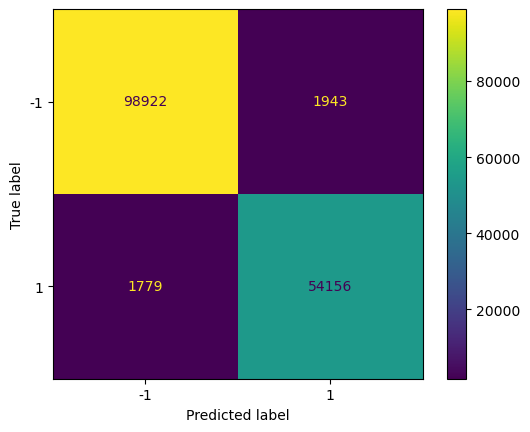

In [14]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


start = time.time()

svm = LinearSVC(random_state=42)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Une seule passe de cross-validation
y_pred_cv = cross_val_predict(svm, X_train_full, y_train_full, cv=cv, n_jobs=-1)

# Calcul de la précision moyenne sur toutes les prédictions CV
acc = accuracy_score(y_train_full, y_pred_cv)

# Matrice de confusion
cm = confusion_matrix(y_train_full, y_pred_cv, labels=[-1,1])
ConfusionMatrixDisplay(cm, display_labels=[-1,1]).plot()

end = time.time()

print("\n--- Validation croisée ---")
print(f"Temps d'exécution : {end - start:.2f} s")
print(f"Précision moyenne (CV) : {acc:.4f}")


La répartition des erreurs est assez symétriques. Nous constatons légèrement plus de faux positifs que de faux négatifs.

---
# Partie 4 - Tuning d'un hyperparamètre
---

### L'hyperparamètre $C$

**Description**

Nous souhaitons trouver l'hyperparamètre $C$ optimal pour le svm linéaire sur notre jeu de données. 

Rappelons ce que contrôle $C$ dans l'algorithme. $C$ est un terme de pénalisation des erreurs de classifications : 
- si $C$ est petit, des erreurs de classifications sont tolérées. La marge du svm est plus large, ce qui en fait un algorithme avec une capacité de généralisation plus importante. 
- si $C$ est grand, moins d'erreurs de classifications sont tolérées car elles sont pénalisées plus sévèrement dans l'algorithme d'optimisation constitutif du svm. Donc, la marge est plus réduite. La précision est normalement plus grande, mais il y a un risque de surapprentissage plus élevé puisqu'on force l'algorithme à potentiellement fixer les hyperplans séparateurs sur des données qui pourraient être du bruit. 

**Influence de $C$ sur la précision**

Les valeurs que nous allons tester : 

In [56]:
C = [0.01, 0.1, 1, 10, 100]

In [ ]:

accuracies = []

for i in range(len(C)):
    svm = LinearSVC(random_state=42, C=C[i])
    svm.fit(X_train_full, y_train_full)
    y_pred = svm.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred)*100)


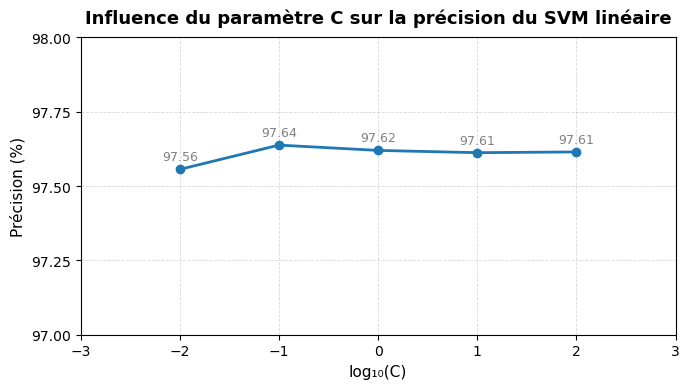

In [45]:

plt.figure(figsize=(7, 4))  # format horizontal compact
plt.plot(np.log10(C), accuracies, marker='o', linestyle='-', color='tab:blue', linewidth=2, markersize=6)

# Mise en forme soignée
plt.title("Influence du paramètre C sur la précision du SVM linéaire", fontsize=13, fontweight='bold', pad=10)
plt.xlabel("log₁₀(C)", fontsize=11)
plt.ylabel("Précision (%)", fontsize=11)
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.5)
plt.xlim(-3, 3)
plt.ylim(97, 98)
plt.xticks(np.arange(-3, 4, 1))
plt.yticks(np.linspace(97, 98, 5))
plt.tight_layout()

# Optionnel : ajoute les valeurs sur les points
for x, y in zip(np.log10(C), accuracies):
    plt.text(x, y + 0.02, f"{y:.2f}", ha='center', va='bottom', fontsize=9, color='gray')

plt.show()


La précision ne varie que légèrement avec C. On constate une légère augmentation de la précision à $C=0.1$. En théorie, on devrait observer une augmentation de la précision plus franche avec C, mais comme celle par défaut est déjà très bonne, on se situe certainement sur un plafond d'amélioration avec C.

**Influence de $C$ sur la généralisation**

Pour rendre compte de la capacité de l'algorithme à généraliser en fonction de l'hyperparamètre $C$, nous allons faire une validation croisée à 3 folds, et relever à chaque fois l'écart type des séries des précisions sur chacun des folds.

In [57]:
# Calcul de l'écart-type de la précision selon C
std = []
for c in C:
    svm = LinearSVC(random_state=42, C=c, max_iter=5000)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(svm, X_train_full, y_train_full, cv=cv, scoring='accuracy', n_jobs=-1)
    std.append(np.std(scores) * 100)  # passage en %


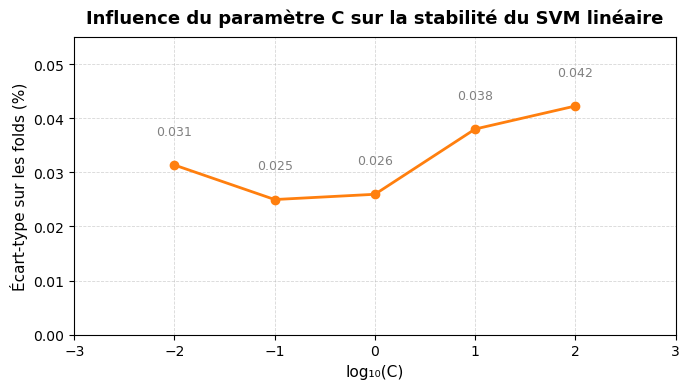

In [59]:

# Tracé du graphe
plt.figure(figsize=(7, 4))
plt.plot(np.log10(C), std, marker='o', linestyle='-', color='tab:orange', linewidth=2, markersize=6)

# Mise en forme esthétique
plt.title("Influence du paramètre C sur la stabilité du SVM linéaire", fontsize=13, fontweight='bold', pad=10)
plt.xlabel("log₁₀(C)", fontsize=11)
plt.ylabel("Écart-type sur les folds (%)", fontsize=11)
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.5)
plt.xlim(-2, 2)
plt.ylim(0, max(std) * 1.3)  # adapte automatiquement à ta plage
plt.xticks(np.arange(-3, 4, 1))

# Valeurs au-dessus des points
for x, y in zip(np.log10(C), std):
    plt.text(x, y + 0.005, f"{y:.3f}", ha='center', va='bottom', fontsize=9, color='gray')

plt.tight_layout()
plt.show()


De même, l'écart type de la distribution sur les folds de la précision ne varie pas beaucoup. On constate, en accors avec la théorie une augmentation de cet écart-type avec C, indiquant une capacité légèrement plus faible de généralisation lorsque C augmente.

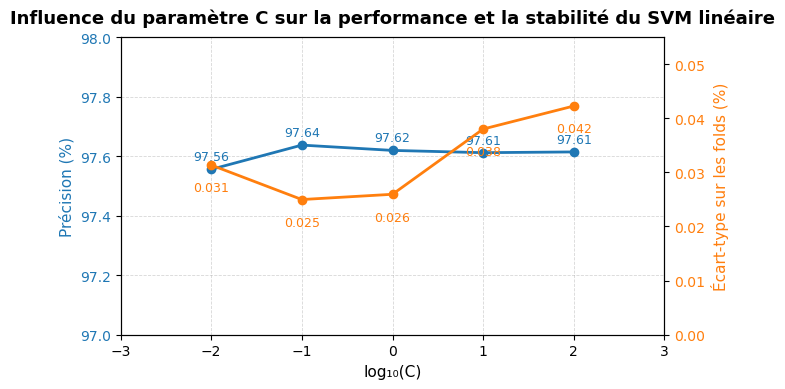

In [62]:

# Création de la figure et de l'axe principal
fig, ax1 = plt.subplots(figsize=(7, 4))

# Axe de gauche : précision
color1 = 'tab:blue'
ax1.plot(np.log10(C), accuracies, marker='o', color=color1, linewidth=2, label='Précision')
ax1.set_xlabel("log₁₀(C)", fontsize=11)
ax1.set_ylabel("Précision (%)", color=color1, fontsize=11)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlim(-3, 3)
ax1.set_ylim(97, 98)
ax1.set_xticks(np.arange(-3, 4, 1))
ax1.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.5)

# Axe secondaire : écart-type
ax2 = ax1.twinx()
color2 = 'tab:orange'
ax2.plot(np.log10(C), std, marker='o', color=color2, linewidth=2, label='Écart-type')
ax2.set_ylabel("Écart-type sur les folds (%)", color=color2, fontsize=11)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0, max(std) * 1.3)

# Gestion intelligente des annotations
for x, y1, y2 in zip(np.log10(C), accuracies, std):
    # Si la précision est plus haute en valeur absolue sur le graphique, texte au-dessus
    if y1 > 97.5:
        ax1.text(x, y1 + 0.02, f"{y1:.2f}", ha='center', va='bottom', fontsize=9, color=color1)
        ax2.text(x, y2 - 0.003, f"{y2:.3f}", ha='center', va='top', fontsize=9, color=color2)
    else:
        ax1.text(x, y1 - 0.02, f"{y1:.2f}", ha='center', va='top', fontsize=9, color=color1)
        ax2.text(x, y2 + 0.003, f"{y2:.3f}", ha='center', va='bottom', fontsize=9, color=color2)

# Titre et mise en forme
plt.title("Influence du paramètre C sur la performance et la stabilité du SVM linéaire",
          fontsize=13, fontweight='bold', pad=10)
plt.tight_layout()
plt.show()


Finalement, il s'agit de trouver un compromis entre la précision obtenue et la capacité de généralisation de l'algorithme. Ici, nous pouvons constater que $C=0,1$ semble optimal, et nous le gardons à cette valeur pour la suite.

Quelques autres hyperparamètres ont été testés, notamment `loss`, que nous avons mis sur `hinge` au lieu de `squared_hinge` par défaut. Mais, cela ne nous a pas apporté d'amélioration significative dans la précision.

---
# Partie 5 : Conclusions
---

Pour conclure, dans ce notebook nous devions entrainer un modèle pour classifier les url entre sain et malsain. 

C'est une tâche de machine learning supervisée puisque les données sont labelisées (-1 pour sain/+1 pour malsain).

Nous avons commencé par mettre en place un feature engineering pour extraire les features utiles à l'entrainement du modèle de machine learning. 

Puis nous avons entrainé et testé plusieurs algorithmes de ML (svm, arbres, naive bayes, Gaussian processes).

Grâce à nos résultats, nous avons montré qu'un simple SVM linéaire suffit à obtenir une bonne précision (97,6%). 

Ensuite nous avons fine tunné l'hyperparamètre $C$. Nous avons pu améliorer notre précision de 0.01%.

Enfin, pour améliorer notre travail si nous avions accès aux personnes "métier", nous aurions pu leur demandé comment ils ont fait pour passer d'un texte url à un vecteur représentant nos features dans la matrice svm. En effet, si nous comprenons mieux à quelles parties de l'url font référence les feature, nous pourrions mieux les filtrer lors de notre feature engineering.
